# Capstone project by Jörg Schreiner

# Political orientation of Swiss communes from a data science perspective

## Introduction

### Problem description

Using the detailed data that is available 
- about the 2'202 __Swiss communes__
- from sources like the __Federal Statistical Office__, the __Federal Tax Administration__, the __Federal Office of Public Health__, or the __State Secretariat for Economic Affairs__, supplemented with less conventional data providers like __Swiss Federal Railways__ or __geographical data__

in this project I will
- use machine learning models to predict the __political orientation__ of the municipalities as expressed in the 2019 federal elections ("Nationalratswahlen")
- identify __significant factors__ that influence the political orientation
- and __compare__ a linear regression model __with two other non-linear regression models__ (gradient tree boosting and support vector regression)

The dependent variable, political orientation, in the context of this project will be a single number that summarizes how far left-leaning or right-leaning a municipality has voted. This will be computed by assigning each party a left/right value and then getting the sum of party values weighted by election results.

Example:

Given these party left/right values

| -2 | -1 | 0 | +1 | +2 |
|---|---|---|---|---|
|GPS|SP |CVP|FDP|SVP|
|PdA| -  |GLP|BDP|RW*|
| - | -  |EVP| - | - |

and these election results

&nbsp; |**GPS**|**SP**|**GLP**|**CVP**|**FDP**|**SVP**
:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:
Lausanne|27%|27%|7%|2%|15%|9%
Schwyz|3%|18%|3%|25%|20%|30%

the political-orientation value is **-0.55 for Lausanne** and **+0.57 for Schwyz**. So Lausanne leans to the left politically and Schwyz to the right. Intuitively that is not surprising. The aim of the capstone project is to quantify it and find out what leads to that (social, economic, geographic, ... factors).

Please consult the notebook [Political Parties in CH](./01b%20Political%20Parties%20in%20CH.ipynb) for a more detailed description of the parties, the political spectrum and the formula for the political orientation value.

### Overview of the data

The data that I will be using for the project is a combination of 11 data files. You can find the list below, together with links to the sources and a description of the contained variables.

At the center of the data files is the regional portraits file. It contains 31 variables about each of the 2'202 Swiss communes (as of 01.01.2020). It also contains the voter shares of 10 political parties in the 2019 federal elections (which we use to calculate the target variable). Each commune has a unique commune id, which is also contained in most other data files. That means I don't have to rely on commune names to join the files (which would be error-prone). In some files, the reference area is not communes, but regions (aka. districts, there are 143 of them) or cantons (there are 26 of them). For these files, the link to the commune can be made because the region and canton of each commune is known from the commune directory.

You can find all files in the data/source subfolder.

### Data sets

**Data Set**|**Source**|**Ref. Area**|**Num. Variables**|**File**|**URL**
-----|-----|-----|-----:|-----|-----
Regional Portraits|FSO|Commune|31|je-e-21.03.01.xlsx|https://www.bfs.admin.ch/bfs/de/home/statistiken/kataloge-datenbanken.assetdetail.11587760.html
Languages|FSO|Commune|1|20584_131.xlsx|https://www.atlas.bfs.admin.ch/maps/13/de/12474_3175_235_227/20584.html
Religion|FSO|Canton|4|24071_131.xlsx|https://www.atlas.bfs.admin.ch/maps/13/de/15297_3522_107_70/24071.html
Health Insurance|FOPH|Sub-Canton|4|praemienregionen-version-maerz-2020|https://www.bag.admin.ch/bag/en/home/versicherungen/krankenversicherung/krankenversicherung-versicherer-aufsicht/praemienregionen.html
Taxable Income|FTA|Commune|1|23875_131.xlsx|https://www.atlas.bfs.admin.ch/maps/13/de/15132_9164_9202_7267/23875.html
Unemployment|SECO|Canton|1|23868_131.xlsx|https://www.atlas.bfs.admin.ch/maps/13/de/15135_128_127_119/23868.html
Crime Rate|FSO|District|1|24033_131.xlsx|https://www.atlas.bfs.admin.ch/maps/13/de/15275_3862_11461_7266/24033.html
Spatial Typology|FSO|Commune|1|20593_131.xlsx|https://www.atlas.bfs.admin.ch/maps/13/de/12360_12482_3191_227/20593.html
Ticket Vending Machines|SBB|Commune|1|billetautomat.csv|https://data.sbb.ch/explore/dataset/billetautomat/information/
Geo Location|FSO|Commune|2|be-b-00.03-gg20.xlsx|https://www.bfs.admin.ch/bfs/en/home/services/geostat/swiss-federal-statistics-geodata/administrative-boundaries/generalized-boundaries-local-regional-authorities.assetdetail.14776427.html
Commune Directory | FSO | Commune |-| be-b-00.04-agv-01.xlsx | https://www.bfs.admin.ch/bfs/de/home/grundlagen/agvch.assetdetail.14709198.html

### Data set variables
<a class="anchor" id="data-set-variables"></a>

**Data Set**|**Variables**
-----|-----
Regional Portraits|Population: residents, change, density, foreigners
&nbsp;|Age distribution, 0-19y, 20-64y, 65+y
&nbsp;|Birth, mortality, marriage, divorce
&nbsp;|Households, number and size
&nbsp;|Area: total, settlements, agricultural, wooded, unproductive, with changes
&nbsp;|Economy: employees, businesses, primary, secondary, tertiary sectors
&nbsp;|Housing: dwelling vacancy, new housing
&nbsp;|Social assistance rate
&nbsp;|Voter shares national elections for 10 parties
Languages|de/fr/it/rm
Religion|Catholic, protestant, other, none
Health Insurance|Average health insurance premium adults and children
Taxable Income|Average taxable income per capita
Unemployment|Unemployment rate
Crime Rate|Crimes per inhabitant
Spatial Typology|City/periurban/rural, density, central/peripheral (9 different types)
Ticket Vending Machines|Geo-locations of SBB ticket vending machines
Geo Location|Coordinates, elevation, area
Commune Directory | Cantons, regions, mergers 

### Data Sources

**Source**|**Source Name**
-----|-----
FSO (BFS)|Federal Statistical Office
FOPH (BAG)|Federal Office of Public Health
FTA (ESTV)|Federal Tax Administration
SECO|State Secretariat for Economic Affairs
SBB|Swiss Federal Railways

## In-depth look at political parties in Switzerland

In the capstone project I am using the voter shares of political parties in the Swiss federal parliament elections ("Nationalsratswahlen") of 2019. The "regional portraits " data set contains the election results for each party in each of the 2202 communes. Later on I will introduce a way to aggregate multiple parties' voter shares to a single indicator variable for the political orientation on a left-right scale. But first I will present a summary of the parties profiles. Here, they are ordered by their voter shares on the national level.

| Party name (de/fr/it) | Abbrev. (de/fr/it) | Wikipedia Link (de/en)  | Ideology  |   |
|---|---|---|---|---|
| **Schweizerische Volkspartei** | **SVP** | https://de.wikipedia.org/wiki/Schweizerische_Volkspartei | national-conservative, right-wing populist  |
| Union démocratique du centre   | UDC   | https://en.wikipedia.org/wiki/Swiss_People%27s_Party  |
| Unione Democratica del Centro   | UDC  |
|
| **Sozialdemokratische Partei**   | **SP**  | https://de.wikipedia.org/wiki/Sozialdemokratische_Partei_der_Schweiz  | social-democratic, socialist  |
| Parti socialiste suisse   | PS  | https://en.wikipedia.org/wiki/Social_Democratic_Party_of_Switzerland  |
| Partito socialista svizzero   |  PS |
|
| **Die Liberalen**   | **FDP**  | https://de.wikipedia.org/wiki/FDP.Die_Liberalen  | liberal, conservative-liberalism  |
| Les Libéraux-Radicaux  | PLR  | https://en.wikipedia.org/wiki/FDP.The_Liberals  |
| I Liberali  | PLR  |
|
| **Grüne Partei**  | **GPS**  | https://de.wikipedia.org/wiki/Grüne_Partei_der_Schweiz  | ecological, progressivism  |
| Parti écologiste suisse   | PES  | https://en.wikipedia.org/wiki/Green_Party_of_Switzerland  |
| Partito ecologista svizzero   | PES  |
|
| **Christlichdemokratische Volkspartei**  | **CVP**  | https://de.wikipedia.org/wiki/Christlichdemokratische_Volkspartei | christian-democratic, social conservatism  |
| Parti démocrate-chrétien   | PDC  | https://en.wikipedia.org/wiki/Christian_Democratic_People%27s_Party_of_Switzerland   |
| Partito Popolare Democratico | PPD  |
|
| **Grünliberale Partei**   | **GLP** | https://de.wikipedia.org/wiki/Grünliberale_Partei  | green liberalism  | 
| Parti vert’libéral   | PVL | https://en.wikipedia.org/wiki/Green_Liberal_Party_of_Switzerland  |
| Partito Verde Liberale  | PVL |
|
| **Bürgerlich-Demokratische Partei** | **BDP**  | https://de.wikipedia.org/wiki/Bürgerlich-Demokratische_Partei  | fiscal conservatism, civil libertarianism  |   |
| Parti bourgeois démocratique | PBD  | https://en.wikipedia.org/wiki/Conservative_Democratic_Party_of_Switzerland  |
| Partito borghese democratico | PBD  | 
|
| **Evangelische Volkspartei** | **EVP**  | https://de.wikipedia.org/wiki/Evangelische_Volkspartei  | christian-democratic, social conservatism  |   |
| Parti évangelique | PEV  | https://en.wikipedia.org/wiki/Evangelical_People%27s_Party_of_Switzerland  |
| Partito Evangelico | PEV  | 
|
| **Partei der Arbeit der Schweiz**   | **PdA**  | https://de.wikipedia.org/wiki/Partei_der_Arbeit_der_Schweiz  | communism, socialism  |   |
| Parti Suisse du Travail   | PST  | https://en.wikipedia.org/wiki/Swiss_Party_of_Labour  |
| Partito Svizzero del Lavoro   | PSL  | 

### The left-right political spectrum

Assigning political positions on a one-dimensional axis that ranges from left to right is obviously a huge simplification. Still, since it was established around the time of the French Revolution, where in the assembly the royalists were sitting on the right side and the republicans were sitting on the left, it has become ubiquitous in the media and political conversation. Everybody seems to intuitively be able to tell if "lowering taxes" or "allowing more immigration" are right or left positions. Since this is not a political science seminar, I do not delve deeper into the subject. I assume that it is possible to locate the Swiss political parties on a left-right axis so that their relative positions are consistent with their programs and the perception of the public.

### Proposed spectrum for the project

I will use an axis that uses integral values from -2 (very left) to +2 (very right) and assign the parties like this:

| -2 | -1 | 0 | +1 | +2 |
|---|---|---|---|---|
|GPS|SP |CVP|FDP|SVP|
|PdA| -  |GLP|BDP|RW*|
| - | -  |EVP| - | - |

\* RW = right-wing parties that are only summarized in the "regional portraits" data set. They have a 2% overall vote share.

I will name the position of a party on that axis the left-right value (short lr-value) of the party. 

### Calculation of political orientation value

The outcome of an election is measured by the number of votes that each party gets. Then the vote share is calculated as the ratio of the party's votes to all votes. 

Given an election, I propose to use the weighted (by vote share) average of left-right values of the parties as an indicator of where on the left-right political spectrum an election result as a whole can be assigned. I will name this weighted average the "political orientation value" (short po-value).

$$\bar{po} = \frac{\sum \limits _{p \in P} lr_p \cdot vs_p}{\sum \limits _{p \in P} vs_p}$$

$\bar{po}$ political orientation value  
$P$ set of all parties  
$lr_p$ left-right value of party p  
$vs_p$ vote share of party p  

We have to divide by the sum of all vote shares because they don't usually add up to exactly 100%.

The political orientation value can be calculated at various levels, e.g.
- for the overall result of the Swiss national parliament elections of 2019
- seperately for each of the Swiss communes where people voted in these elections
- in analogy, you can also compute the po-value for the parliament itself, using the number of representatives of each party instead of the election vote count
- or even for the national government, where each of the 7 members belongs to one of the parties

The political orientation value is a meaningful value, it can be used to derive statements like:
- in the 2019 national elections, the parliament moved to the left compared to 2015
- larger cities tend to be more politcal left than small rural communes
- the national government's composition is more to the right than the parliament

In the capstone project, I will use the po-values of the Swiss communes as the independent variable and try to predict it using various features of the communes.

### Political polarization

While the po-value as an average gives important information about an electorate or an assembly, it does not convey the complete picture. There is also the aspect of political polarization. Basically that means: in a very polarized environment, most votes go the parties at the extreme ends of the spectrum, while the center parties have a low share of votes. In another, less polarized environment, most votes go to center parties. Still both environments could have similar po-values.

To quantify the political polarization, one can use the weighted (by vote share) standard deviation of the left-right values of the parties, using the po-value from above as the weighted mean.

$$\sigma = \sqrt{\frac {\sum \limits _{p \in P} (lr_p - \bar{po})^2 vs_p} {\sum \limits _{p \in P} vs_p}}$$

$\sigma$ weighted standard deviation, represents political polarization  
$P$ set of all parties  
$lr_p$ left-right value of party p  
$\bar{po}$ weighted mean, represents political orientation  
$vs_p$ vote share of party p  

Examples:
- highly polarized, 50% at +/-2: $\bar{po}$ = 0, $\sigma$ = 2
- flat, 20% at each lr-value: $\bar{po}$ = 0, $\sigma$ = 1.4
- centric, 10% at +/-2, 20% at +/-1, 40% at 0: $\bar{po}$ = 0, $\sigma$ = 1.1

The political polarization is certainly a meaningful value. High polarization is generally not considered to be a good thing for society. Fortunately, in Switzerland (in the 2019 data set we use), mean polarization is 1.3 and 95th percentil is 1.55.

The political polarization will not be used in the capstone project, because it is better to concentrate on one thing at a time, and because the above numbers show that polarization is only benign in Switzerland.

## Implementation

In the following cells, I will import the data file that contains the voter shares of the 2019 Nationalrat elections for each commune. Then I will compute the political orientation (mean) values and the polarization (standard deviation). I will examine the the distributions of the two variables. Finally, I will check the correlations between parties' vote shares and the po-value to support the soundness of the po-value.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math

In [2]:
# read the regional portraits
df = pd.read_excel(os.path.join("data", "source", "je-e-21.03.01.xlsx"), header = 5, skipfooter=21)
df.drop(range(0,3), inplace=True) # drop some filler rows between header and data
# use easily readable and consistent column names
new_cols = ['commune_id', 'name', 'residents', 'population_change',
       'population_density', 'foreign_nationals_percent', 'age_0_19',
       'age_20_64', 'age_65_over', 'marriage_rate',
       'divorce_rate', 'birth_rate', 'mortality_rate',
       'households', 'households_size',
       'surface_area', 'settlement_urban_area_percent',
       'settlement_urban_area_change', 'agricultural_area_percent', 'agricultural_area_change',
       'wooded_area_percent', 'unproductive_area_percent', 'employed_total',
       'employed_primary_sector', 'employed_secondary_sector', 'employed_tertiary_sector',
       'workplaces_total', 'workplaces_primary_sector',
       'workplaces_secondary_sector', 'workplaces_tertiary_sector', 'dwelling_vacancy_rate',
       'new_housing_rate', 'social_assistance_rate',
       'vote_share_fdp', 'vote_share_cvp', 'vote_share_sp', 'vote_share_svp', 'vote_share_evp', 'vote_share_glp', 'vote_share_bdp', 'vote_share_pda',
       'vote_share_gps', 'vote_share_rightwing']
df.columns = new_cols
df.set_index("commune_id", inplace=True)

In [3]:
# missing values in voter shares are '*'
# we can set them to 0 to ignore them
vote_share_cols = [col for col in df.columns if col.startswith("vote_share_")]
for col in vote_share_cols:
    df[col].replace(to_replace=["*"], value=0, inplace=True)

# add a column with the total; this is usually not 100%
df["vote_share_total"] = df[vote_share_cols].sum(axis=1)

df = df.apply(pd.to_numeric, errors='ignore')

In [4]:
# calculate the po-values
# same order of parties as in vote_share_cols is important
party_lr_dict = {"fdp": 1, "cvp": 0, "sp": -1, "svp": 2, "evp": 0, "glp": 0, "bdp": 1, "pda": -2, "gps": -2, "rightwing": 2 }
party_lr_array = np.array(list(party_lr_dict.values()))
df["po_value"] = np.dot(df[vote_share_cols].values, party_lr_array) / df["vote_share_total"]
# there are six small communes that don't have vote results
# df[df["po_value"].isna()]
df.dropna(subset=["po_value"], inplace=True)

In [5]:
# calculate the polarization (standard deviation)
# for each party p's vote share 
# sd = sqrt(sum_all_p((lr_p - po_value)^2 * vote_share_p)/vote_share_total)

def calc_vote_sd(row):
    sows = 0 # sum of weighted squares
    for (lr_p, share_col_p) in zip(party_lr_array, vote_share_cols):
        sows = sows + (lr_p - row["po_value"])**2 * row[share_col_p]
    return math.sqrt(sows / row["vote_share_total"])

df["vote_sd"] = df.apply(calc_vote_sd, axis=1)

In [6]:
df2 = df[vote_share_cols + ["po_value", "vote_sd"]]
df2.head(3)

,vote_share_fdp,vote_share_cvp,vote_share_sp,vote_share_svp,vote_share_evp,vote_share_glp,vote_share_bdp,vote_share_pda,vote_share_gps,vote_share_rightwing,po_value,vote_sd
commune_id,,,,,,,,,,,,
1.0,16.421045,2.497974,11.565102,30.380959,3.227470,14.317294,1.263724,0.162110,15.050475,3.820647,0.446755,1.448863
2.0,13.385437,4.535341,14.645255,30.306920,6.618556,12.666629,2.001445,0.198718,12.590564,1.555518,0.394784,1.400791
3.0,15.354984,3.867961,16.742891,26.116313,4.194018,16.237935,1.284030,0.176013,12.368531,1.385022,0.305028,1.373906


In [7]:
df2[["po_value", "vote_sd"]].describe(percentiles=[.25, .5, .75, .95]).T

,count,mean,std,min,25%,50%,75%,95%,max
po_value,2196.0,0.483413,0.395245,-0.734976,0.214848,0.482292,0.734602,1.160853,1.776557
vote_sd,2196.0,1.323561,0.167104,0.416553,1.252139,1.345967,1.422807,1.548371,1.774299


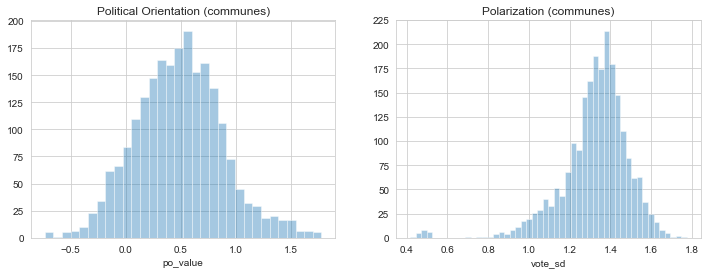

In [8]:
sns.set_style('whitegrid')
fig, axs = plt.subplots(1, 2, figsize = (12, 4))
sns.distplot(df2["po_value"], kde=False, ax=axs[0]).set_title("Political Orientation (communes)")
sns.distplot(df2["vote_sd"], kde=False, ax=axs[1]).set_title("Polarization (communes)")
plt.show()

### po-value

The po-value of the Swiss communes has a mean of 0.48 and a standard deviation of 0.40. It is almost symmetrical and resembles a normal distribution. That should make it a useful target variable for our models.

Please note that it is not to be expected for the mean to be at 0. The data contains one entry for each commune, regardless of its size. That overrepresents small communes, which tend to be more right. Also, there is no need for the political landscape to be neutral at any specific moment in time.

### polarization (std. dev.)

The mean polarization of Swiss communes is 1.32. That is between the centric and flat examples described above. Only 5% of communes have a polarization above 1.55, which is still almost the flat example.

I see this as a good sign for the Swiss political system. And I do not see a reason to discard the po-value as a problematic variable on the grounds that it would for some unclear reason somehow not be usable when the polarization is very high, when such high polarization does not even occur in reality.

### Correlations

We look at the correlations between parties and the po-value. Correlations between parties can also be interesting to analyze voters' behaviour.

Before we look at the numbers, what do we expect? Let us focus on the larger parties, because the impact of the smaller ones (EVP, BDP, PdA, RW) is limited by their small voter share.

1. Parties on the extremes (GPS -2, SVP +2): when SVP (GPS) gain votes, these must be at the expense of parties that are less extreme. That means, the po-value moves to the right (SVP) / to the left (GPS). We certainly expect strong correlations, positive (SVP) or negative (GPS).

2. For not-extreme parties, it's actually more complicated. When such parties gain votes, at the expense of which other parties is it? Is it more from the center/the other side? Then the correlation to the po-value will have the same sign as their lr-value. This seems intuitive. But the other case is possible as well. A party can gain at the expense mostly of another more extreme party on the same side of the spectrum. Then the correlation has the opposite sign as their lr-value. That is not intuitive, but it is completely possible.

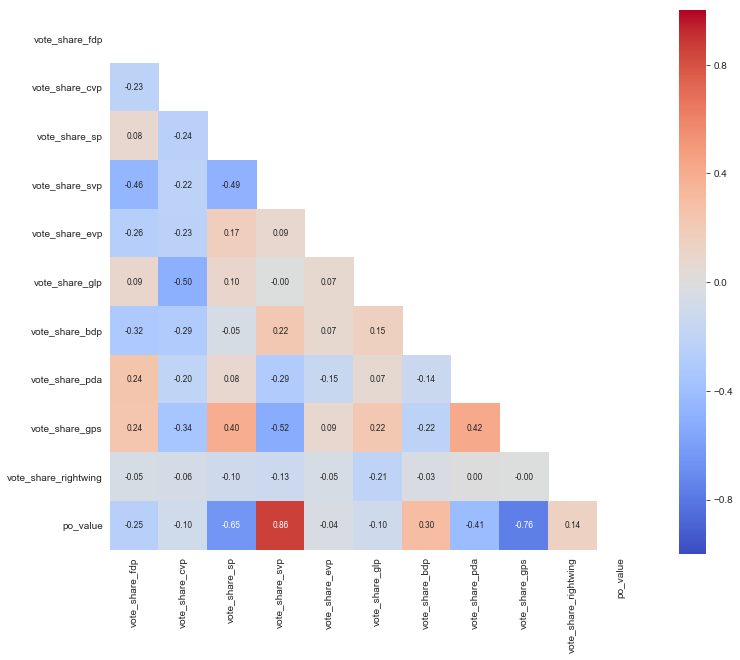

In [9]:
plt.figure(figsize = (12,10))
corr = df2.drop(columns=["vote_sd"]).corr()
sns.heatmap(corr, annot = True, fmt = '.2f',
            square=True, vmin = -1, vmax = 1, cmap= 'coolwarm', mask = np.triu(corr), annot_kws = {"fontsize":"small"});

### Interpretation

When we look at po-value / party correlations: What do we see and how does it fit the expectations from above?

1. Indeed the two extreme political parties SVP and GPS have strong correlations with the po-value, and the sign is the same as their lr-value (SVP +0.86, GPS -0.76).

2. a) For SP, the correlation is -0.65, which is the intuitive case. It seems SP can gain votes mostly from parties to its right. If you look at the SP/GPS correlation, you see that SP gains do generally come with GPS gains as well!

2. b) On the right side, things are different. FDP has only weak correlation -0.25 with the po-value and the sign is, unintuitively, negative. Our theory was that this is possible when FDP gains come at the expense of SVP losses. If you look at the FDP/SVP correlation of -0.46, you see that this is true. Negative correlations of FDP with parties to the left of it are weaker or non-existent.

2. c) CVP and GLP in the center are uncorrelated (-0.10) with the po-value. That suggests that their gains occur in a left-right balanced way. Indeed they have no significant correlations with other parties except amongst themselves (-0.50), which is left-right-neutral.

### Summary

The correlation analysis supports the usefulness of the po-value variable after you take into account the fact that voter movements are not uniform. An interesting insight about the different (non-symmetrical) properties of SP and FDP vote shares.